In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/Users/itobuz/data.csv")

In [4]:
# Target encoding for 'department'
department_target_encoding = df.groupby('department')['reordered'].mean()
df['department_encoded'] = df['department'].map(department_target_encoding)

# Target encoding for 'aisle'
aisle_target_encoding = df.groupby('aisle')['reordered'].mean()
df['aisle_encoded'] = df['aisle'].map(aisle_target_encoding)

# Target encoding for 'product_name'
product_name_target_encoding = df.groupby('product_name')['reordered'].mean()
df['product_name_encoded'] = df['product_name'].map(product_name_target_encoding)

df = df.drop(columns=['product_name', 'department', 'aisle'])

In [19]:
df.columns

Index(['product_id', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'reordered', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'aisle_encoded', 'product_name_encoded', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
       'preferred_order_dow', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')

In [7]:
import pandas as pd

def stratified_sample(df, stratify_col, frac):
    
    stratified_df = df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))

    stratified_df = stratified_df.reset_index(drop=True)
    
    return stratified_df


stratified_df = stratified_sample(data, 'reordered', frac=0.3)

In [5]:
# Define time of day buckets
def time_of_day(hour):
    if hour < 12:
        return 0
    elif hour < 18:
        return 1
    elif hour < 22:
        return 2
    else:
        return 3
df['time_of_day'] = df['order_hour_of_day'].apply(time_of_day)
# Days Since Last Purchase
df['days_since_last_purchase'] = df.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(-1).fillna(0)
# Number of orders per user
df['user_order_count'] = df.groupby('user_id')['order_id'].transform('count')
# Sum of items ordered per order
df['total_items_ordered'] = df.groupby('order_id')['add_to_cart_order'].transform('sum')
# Total orders for each product
df['product_popularity'] = df.groupby('product_id')['order_id'].transform('count')
# Average order hour for each user
df['avg_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
# Order Frequency
df['order_frequency'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')
# Product Affinity by Department
df['department_affinity'] = df.groupby(['user_id', 'department_id'])['order_id'].transform('count') / df.groupby('user_id')['order_id'].transform('count')
# Time of Purchase Features
df['preferred_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
df['preferred_order_dow'] = df.groupby('user_id')['order_dow'].transform('mean')
# Average Reorder Rate
df['avg_reorder_rate'] = df.groupby(['user_id'])['reordered'].transform('mean')
# Product Reorder Frequency (across all users)
df['product_reorder_frequency'] = df.groupby('product_id')['reordered'].transform('sum')
# User's Reorder Rate for Product
df['user_product_reorder_rate'] = df.groupby(['user_id', 'product_id'])['reordered'].transform('mean')
# Order Count for Product by User
df['user_product_order_count'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')

In [6]:
df.columns

Index(['product_id', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'reordered', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'department_encoded', 'aisle_encoded', 'product_name_encoded',
       'time_of_day', 'days_since_last_purchase', 'user_order_count',
       'total_items_ordered', 'product_popularity', 'avg_order_hour',
       'order_frequency', 'department_affinity', 'preferred_order_hour',
       'preferred_order_dow', 'avg_reorder_rate', 'product_reorder_frequency',
       'user_product_reorder_rate', 'user_product_order_count'],
      dtype='object')

In [7]:
# List of pairs of correlated columns to drop one from each
columns_to_drop = [
    ('aisle_encoded' , 'department_encoded'),
   ('order_hour_of_day', 'time_of_day'),   #Drop one from this pair
   ('product_popularity', 'product_reorder_frequency'),  # Drop one from this pair
   ('avg_order_hour', 'preferred_order_hour'),  # Drop one from this pair
    ('order_frequency', 'user_product_order_count')  # Drop one from this pair
]

# Drop one column from each pair
for col1, col2 in columns_to_drop:
    df = df.drop(columns=[col2])  # Drop the second column in each pair

# Verify the changes by printing the remaining columns
print(df.columns)

Index(['product_id', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'reordered', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'aisle_encoded', 'product_name_encoded', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
       'preferred_order_dow', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')


**Time of day buckets**
`# Time of day is categorized into 4 buckets: morning, afternoon, evening, and night.`  
`# This helps capture temporal patterns in user behavior. For example, some users may prefer ordering in the morning, while others may prefer evening or night orders.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Days Since Last Purchase**  
`# This calculates the days since a user last purchased a specific product.`  
`# It is a useful metric for understanding the user's purchase cycle and identifying products that may be due for reordering.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Number of orders per user**  
`# This feature tracks the total number of orders placed by a user.`  
`# Users who place more orders are more engaged and might have a higher likelihood of purchasing similar items in the future.`  
`# It helps in understanding user activity and engagement, which is key for personalization.`

---

**Sum of items ordered per order**  
`# This calculates the total number of items ordered in each order.`  
`# Orders with more items may indicate bulk buying or more diverse product preferences, which can be useful for recommending related items.`  
`# It helps to infer user preferences and buying habits, which improves recommendations.`

---

**Total orders for each product**  
`# This feature measures the popularity of each product by counting how many times it has been ordered across all users.`  
`# It is important for product recommender systems to give higher priority to popular items, as they tend to be more frequently purchased.`  
`# Popular products are often good candidates for recommendations.`

---

**Average order hour for each user**  
`# This calculates the average hour of the day when a user places orders.`  
`# It helps in identifying time-based purchasing patterns, allowing recommendations to align with the user's preferred order times.`  
`# Users who typically order at certain times may be more likely to buy products recommended during those times.`

---

**Order Frequency**  
`# This tracks how often a user purchases the same product.`  
`# High-frequency orders for a product indicate a strong preference or habit, which is important for identifying repeat purchases and cross-selling opportunities.`  
`# This feature helps in recommending products that a user frequently purchases.`

---

**Product Affinity by Department**  
`# This calculates the proportion of orders within a department for each user.`  
`# It helps to understand a user's affinity for different product departments (e.g., electronics, groceries).`  
`# It enables personalized recommendations based on user’s department preferences, improving the relevance of suggested products.`

---

**Time of Purchase Features: Preferred Hour and Day of Week**  
`# These features capture the user's preferred time of day and day of the week for placing orders.`  
`# Understanding when a user tends to make purchases can help recommend products at the right times, improving the likelihood of conversion.`  
`# It enhances temporal personalization in product recommendations.`

---

**Average Reorder Rate**  
`# This measures the average likelihood of a user reordering items.`  
`# A higher reorder rate indicates that the user is more likely to repurchase items they've ordered in the past.`  
`# This feature is important for recommending products the user may wish to reorder based on their previous behaviors.`

---

**Product Reorder Frequency (across all users)**  
`# This feature calculates how often a product is reordered across all users.`  
`# Products that are frequently reordered are strong candidates for recommendation, as they have a high likelihood of being bought again.`  
`# It helps to surface products that are not only popular but also have a high tendency for repeat purchases.`

---

**User's Reorder Rate for Product**  
`# This feature measures the likelihood that a specific user will reorder a specific product.`  
`# It helps to capture individual user-product interactions, which can be crucial for personalized product recommendations.`  
`# It enhances the ability to predict which products a user is most likely to reorder.`

---

**Order Count for Product by User**  
`# This calculates the number of times a user has ordered a specific product.`  
`# It is helpful for identifying products with high user-specific engagement, which can be used for creating personalized recommendations.`  
`# Products with higher order counts are more likely to be recommended to users who have shown strong interest in them.`

In [8]:

# Initialize the scaler
scaler = MinMaxScaler()

# List the columns to scale
columns_to_scale = ['product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'aisle_encoded', 'product_name_encoded',
       'days_since_last_purchase', 'user_order_count', 'total_items_ordered',
       'product_popularity', 'avg_order_hour', 'order_frequency',
       'department_affinity', 'preferred_order_dow', 'avg_reorder_rate',
       'user_product_reorder_rate'
    ]
# Fit and transform the scaler on the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [9]:
# Assuming df is your DataFrame and 'reordered' is the target variable
X = df.drop(columns=['reordered'])  # Features
y = df['reordered']  # Target variable

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
X.columns

Index(['product_id', 'aisle_id', 'department_id', 'order_id',
       'add_to_cart_order', 'user_id', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'aisle_encoded',
       'product_name_encoded', 'days_since_last_purchase', 'user_order_count',
       'total_items_ordered', 'product_popularity', 'avg_order_hour',
       'order_frequency', 'department_affinity', 'preferred_order_dow',
       'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')

In [13]:
# Fit Logistic Regression model
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [16]:
# Split X_test and y_test further into test and validation sets (50% each)
X_test_final, X_val, y_test_final, y_val = train_test_split(X_test, y_test, test_size=0.15, random_state=42)

# Predict on the test set
y_pred = log_reg.predict(X_test_final)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test_final, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Alternatively, using the model's score method
accuracy_alternate = log_reg.score(X_test, y_test)
print(f"Model Accuracy (using score method): {accuracy_alternate:.4f}")

# Predict on the final test set
y_test_pred = log_reg.predict(X_test_final)

# Calculate the F1 score
f1 = f1_score(y_test_final, y_test_pred)
print(f"Model Accuracy (using f1-score method): {accuracy_alternate:.4f}")

Model Accuracy: 0.8584
Model Accuracy (using score method): 0.8585
Model Accuracy (using f1-score method): 0.8585


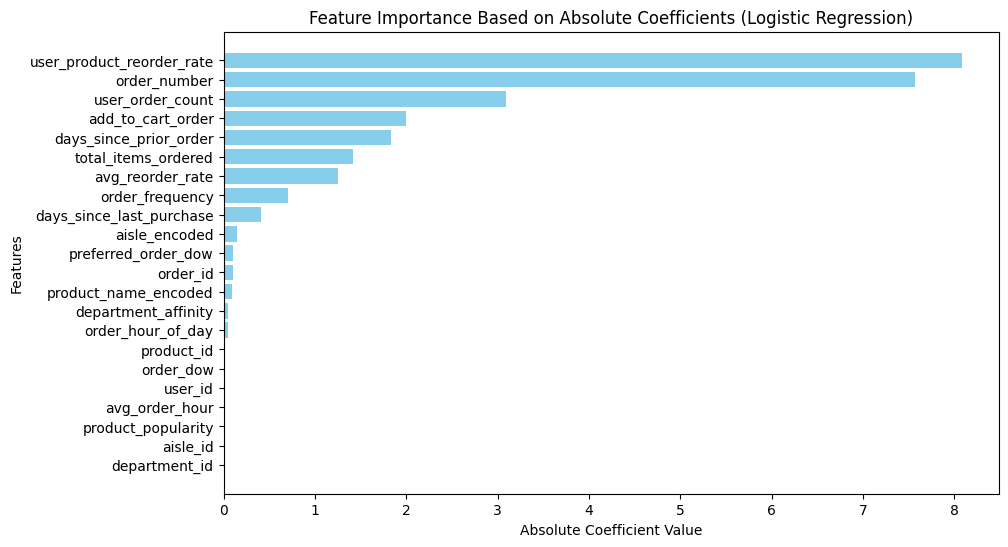

In [17]:
# Assuming you have already trained your Logistic Regression model
# and 'log_reg' is your fitted model

# Get the absolute value of coefficients
importance = np.abs(log_reg.coef_[0])

# Get feature names from X (features dataframe)
feature_names = X.columns

# Create a DataFrame to store feature names and their corresponding importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Absolute Coefficients (Logistic Regression)')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()


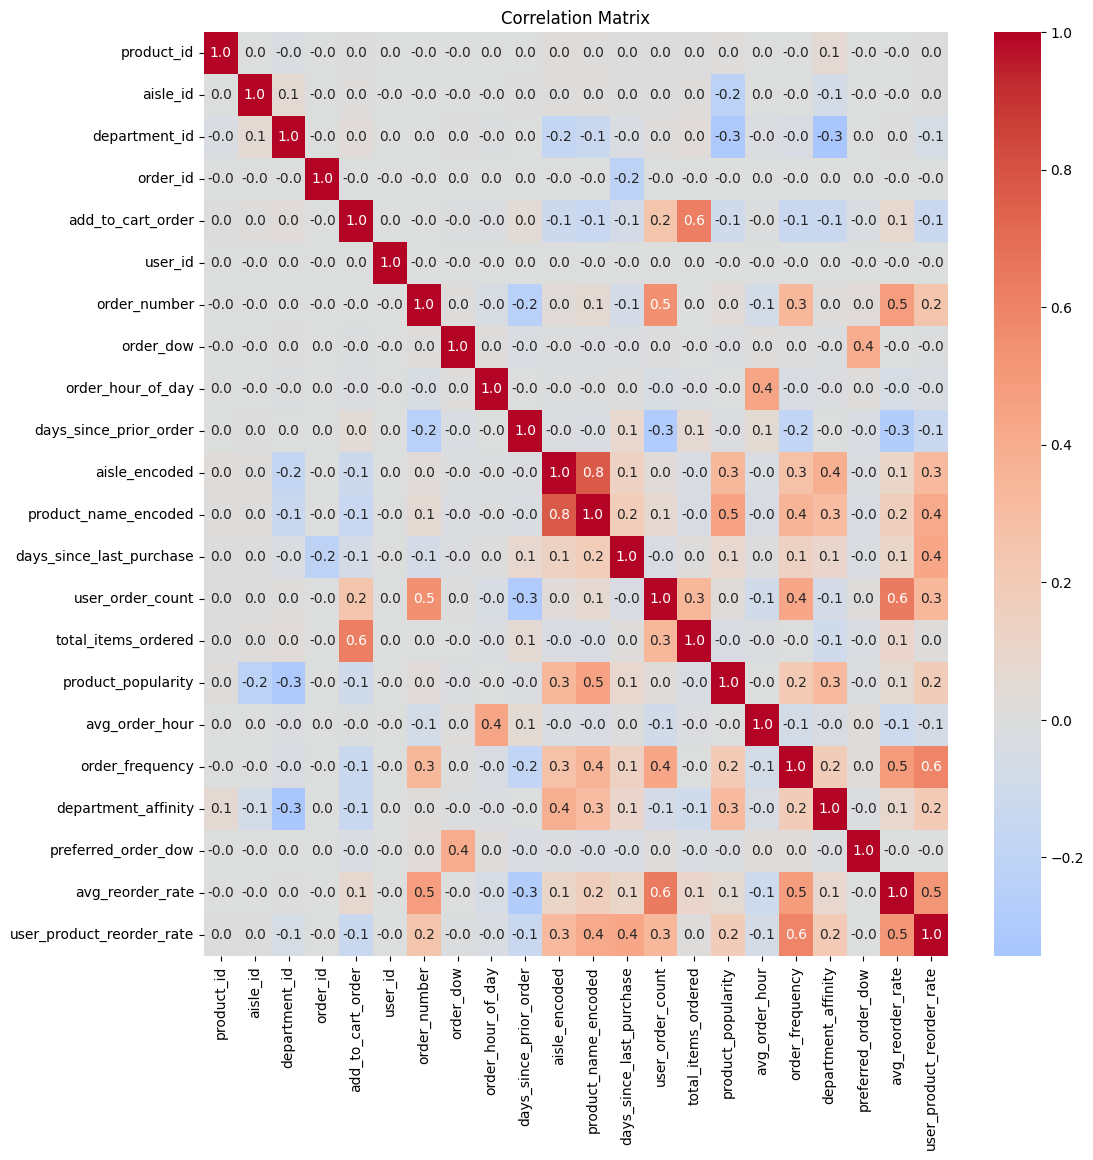

In [20]:

# Correlation Matrix - To identify highly correlated features
corr_matrix = X.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set a threshold for high correlation
threshold = 0.8

# Find pairs of highly correlated columns (excluding the diagonal)
highly_correlated = []

# Iterate through the upper triangle of the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            highly_correlated.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display highly correlated column pairs
for col1, col2, corr_value in highly_correlated:
    print(f"Columns '{col1}' and '{col2}' have a correlation of {corr_value:.2f}")

In [23]:
correlation_matrix

,product_id,aisle_id,department_id,order_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,...,days_since_last_purchase,user_order_count,total_items_ordered,product_popularity,avg_order_hour,order_frequency,department_affinity,preferred_order_dow,avg_reorder_rate,user_product_reorder_rate
product_id,1.000000,0.002254,-0.028503,-0.000082,0.005529,0.003718,0.000080,-0.001925,-0.002350,0.000942,...,0.002928,0.003221,0.003902,0.013959,0.001595,-0.007250,0.056461,-0.004122,-0.002020,0.005014
aisle_id,0.002254,1.000000,0.062203,-0.000063,0.009451,0.003924,-0.000114,-0.000293,-0.001997,-0.001134,...,0.006532,0.007095,0.010323,-0.219773,0.001443,-0.002696,-0.074306,-0.001058,-0.000817,0.005292
department_id,-0.028503,0.062203,1.000000,-0.000229,0.029437,-0.039371,0.000056,0.000529,0.004398,-0.008837,...,-0.024331,0.018380,0.024798,-0.301762,-0.019512,-0.029315,-0.343624,0.002193,0.003968,-0.053100
order_id,-0.000082,-0.000063,-0.000229,1.000000,-0.000320,-0.000253,-0.000482,-0.000543,0.001205,0.000652,...,-0.209219,-0.001380,-0.000600,-0.000194,0.001053,-0.000614,0.000039,0.000514,-0.001225,-0.000889
add_to_cart_order,0.005529,0.009451,0.029437,-0.000320,1.000000,-0.133024,0.000729,-0.004228,-0.009071,-0.014805,...,-0.061300,0.248878,0.617810,-0.092890,-0.008720,-0.138470,-0.129145,-0.026085,0.077172,-0.136759
reordered,0.003718,0.003924,-0.039371,-0.000253,-0.133024,1.000000,-0.000862,0.306840,-0.006949,-0.023300,...,0.295812,0.245759,0.010165,0.139488,-0.041983,0.440663,0.157066,-0.000173,0.386702,0.741459
user_id,0.000080,-0.000114,0.000056,-0.000482,0.000729,-0.000862,1.000000,-0.000768,-0.001630,-0.000415,...,-0.000754,0.001902,0.001314,-0.000443,-0.000940,-0.000426,0.000397,-0.004039,-0.002229,-0.001163
order_number,-0.001925,-0.000293,0.000529,-0.000543,-0.004228,0.306840,-0.000768,1.000000,0.015209,-0.040049,...,-0.065244,0.547467,0.000119,0.026628,-0.074002,0.337741,0.010925,0.034170,0.475182,0.249344
order_dow,-0.002350,-0.001997,0.004398,0.001205,-0.009071,-0.006949,-0.001630,0.015209,1.000000,0.012176,...,-0.014535,0.004840,-0.007071,-0.013104,0.008706,0.003958,-0.010518,0.403594,-0.000181,-0.008410
order_hour_of_day,0.000942,-0.001134,-0.008837,0.000652,-0.014805,-0.023300,-0.000415,-0.040049,0.012176,1.000000,...,0.003229,-0.040349,-0.020719,-0.001945,0.441857,-0.034412,-0.018132,0.009532,-0.047972,-0.027420


In [27]:
#Univariate Statistical Tests (ANOVA F-test)
# Select the top 10 features based on ANOVA F-statistic
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Top 10 features based on ANOVA F-test: {selected_features}")

Top 10 features based on ANOVA F-test: Index(['add_to_cart_order', 'order_number', 'days_since_last_purchase',
       'user_order_count', 'product_popularity', 'avg_order_hour',
       'order_frequency', 'department_affinity', 'avg_reorder_rate',
       'user_product_reorder_rate'],
      dtype='object')


In [26]:
#L1 Regularization (Lasso)** - Feature selection via Lasso
lasso = Lasso(alpha=0.01)  # Lasso regularization
lasso.fit(X, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features using Lasso regularization: {lasso_selected_features}")

Selected features using Lasso regularization: Index(['order_number', 'days_since_prior_order', 'user_product_reorder_rate'], dtype='object')
